# Script to get ECB Yield Curve Time Series Data and Visualizing it
This script will retrieve yield curve time series data from the ECB SDM 2.1 RESTful web service through making a http get request. Basically, it is like a function replicating the `sdw_api` python package from the ECB, but is more flexible in the sense that it does not throw an error for the yield curve data across different maturities, which was the case for the api package.

In [1]:
# To make web requests at the ECB SDMX 2.1 RESTful web service
import requests

# For use of the ECB API
#from sdw_api import SDW_API

# Standard libs for data manipulation
import pandas as pd
import numpy as np
import io
from datetime import date
import re

# For Visualization
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.core.pylabtools import figsize

In [2]:
# Read in the keys for the data time series of the yield curve from 3-month residual maturity to 30-years resid maturity
# for all ratings and all issuers
keys_df=pd.read_excel('assets/keys.xlsx')

In [3]:
# Now get the keys into a list
keys_list=keys_df['keys'].tolist()

### Create the Yield Curve Dataframe
The standard entrypoint for the ECB SDMX 2.1 RESTful web service is `https://sdw-wsrest.ecb.europa.eu/service/data/`.<br>
We then make an empty list in which we will store each individual dataframe which we will have received from the https get request on basis of the time series keys in 'keys_list'.

#### Note on the methodology
**re.findall()** function returns all non-overlapping matches of a pattern in a string. 
The function returns all the findings as a list. The search happens from left to right.<br>

- **(\w+)**: The _\w_ matches a "word character"— something alphanumeric or an underscore; 
the + matches one or more of these; and the parentheses group and store them in the first capturing group.
- **\\.**: It stops when it sees a fullstop '.', which needs to be escaped with '\\'.

Hence, this method splits the time series key into its constituent parts and stores them in variables.<br>
As for the `keyRemainder` we join, so to say, the 'remainder' of the time series key after having isolated the database identifier (e.g. YC, for 'Yield Curve' dataflow) by putting '\.' regex in the front of '(\w+)'. <br>
We do this iteratively for each time series key in a for loop.

In [53]:
# OPEN TO DO: TURN THIS INTO A FUNCTION
# Entrypoint for the ECB SDMX 2.1 RESTful web service
entrypoint="https://sdw-wsrest.ecb.europa.eu/service/data/"

pd_list=[]

for i in keys_list:
    #===============================================================
    # store time series (ts) key components in a list
    keyComponent_list = re.findall(r"(\w+)\.",i)
    # access the database identifier, which is the very first component at index 0
    db_id = keyComponent_list[0]
    # remainder of key components
    keyRemainder = '.'.join(re.findall(r"\.(\w+)",i))
    # merge the request url
    requestUrl= entrypoint + db_id+ "/" + keyRemainder + "?format=genericdata"
    #--------------------------------------------------------------
    
    # Set parameters for http request get method
    today = date.today()        # get the date of today
    today_formatted = today.strftime("%Y-%m-%d") # format the date as a string 2020-10-31
    parameters = {
    'startPeriod': '2023-03-08', #'2019-01-01',  # Start date of the time series
    'endPeriod': today_formatted     # End of the time series
    }
    #--------------------------------------------------------------
    
    # Make the HTTP get request for each url
    response = requests.get(requestUrl, params=parameters, headers={'Accept': 'text/csv'})
    assert response.status_code == 200, f"Expected response code 200, got {response.status_code} for {requestUrl}. Check again your url!"
    #--------------------------------------------------------------

    # Read the response as a file into a Pandas Dataframe
    yc_df = pd.read_csv(io.StringIO(response.text))
    # Create a new DataFrame called 'yield_ts'; isolating Time Period and Observation Value only.
    yield_ts = yc_df.filter(['TIME_PERIOD', 'OBS_VALUE'], axis=1)
    #--------------------------------------------------------------
    
    # Identify the dataframe with its residual maturity; if >9 years it will be 10, 11, etc.
    # so prepare string variable as the column name
    name_num=keyRemainder[29]
    name_freq=keyRemainder[30]
    name_short=name_num+name_freq
    if (name_freq!='Y') and (name_freq!='M'):
        name_long=name_short#+'Y'
        yield_ts.rename(columns={'OBS_VALUE':name_long}, inplace=True)
    elif name_freq=='Y':
        name_long=name_short[0]
        yield_ts.rename(columns={'OBS_VALUE':name_long}, inplace=True)
    else:
        yield_ts.rename(columns={'OBS_VALUE':'M'+name_short[0]}, inplace=True)
    #--------------------------------------------------------------
    
    # 'TIME_PERIOD' was of type 'object' (as can be seen in yc_df.info). Convert it to datetime first
    #yield_ts['TIME_PERIOD'] = pd.to_datetime(yield_ts['TIME_PERIOD'])
    # Set 'TIME_PERIOD' to be the index
    #yield_ts = yield_ts.set_index('TIME_PERIOD')
    # Append individual dataframe to pd_list
    pd_list.append(yield_ts)
    #===============================================================
    
# Now concatenate each individual yield curve dataframe from the list of dataframes,
# collected in the loop, into one single dataframe
yieldCurve_df=pd.concat(pd_list, axis=1)
yc_df=yieldCurve_df.drop("TIME_PERIOD", axis=1).T.reset_index()
yc_df.rename(columns={'index':'Maturity', 0:'Value'}, inplace=True)
yc_df['date']='2023-03-08'

In [54]:
yc_df=yc_df.set_index('date', inplace=False)

In [61]:
yc_df_sorted=yc_df.sort_values("Maturity")
yc_df_sorted

,Maturity,Value
date,,
2023-03-08,1,3.392160
2023-03-08,10,3.398540
2023-03-08,11,3.424740
2023-03-08,12,3.448260
2023-03-08,13,3.468887
2023-03-08,14,3.486570
2023-03-08,15,3.501352
2023-03-08,16,3.513335
2023-03-08,17,3.522654


In [65]:
yc_df_m=yc_df_sorted.iloc[30:33,:]
yc_df_y=yc_df_sorted.iloc[0:30,:]#.sort_values("Maturity")
yc_df_y['Maturity']=pd.to_numeric(yc_df_y['Maturity'])
yc_df_y_sort=yc_df_y.sort_values("Maturity")
yc_df_m

C:\Users\Test\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Maturity,Value
date,,
2023-03-08,M3,2.849609
2023-03-08,M6,3.149814
2023-03-08,M9,3.312858


In [66]:
yc_df_final=pd.concat([yc_df_m, yc_df_y_sort])
yc_df_final

,Maturity,Value
date,,
2023-03-08,M3,2.849609
2023-03-08,M6,3.149814
2023-03-08,M9,3.312858
2023-03-08,1,3.392160
2023-03-08,2,3.388947
2023-03-08,3,3.308614
2023-03-08,4,3.271054
2023-03-08,5,3.268539
2023-03-08,6,3.285266


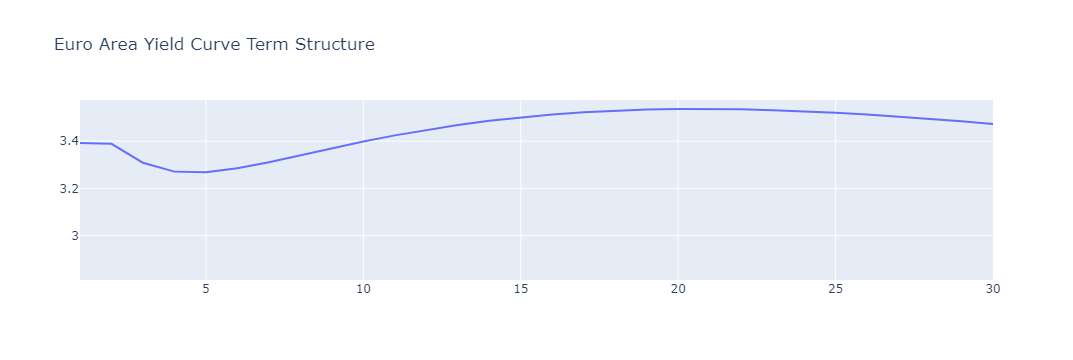

In [67]:
import plotly.graph_objects as go
fig=go.Figure()
fig.add_trace(go.Scatter(x=yc_df_final["Maturity"], y=yc_df_final["Value"]))
fig.update_layout(title="Euro Area Yield Curve Term Structure")
fig.show()